In [14]:
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm, Normalize

from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import matplotlib
import numpy as np
import copy
from scipy.ndimage import gaussian_filter
import os
import h5py
import json
import pandas as pd
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib
matplotlib.rcParams['mathtext.rm'] = 'serif'
matplotlib.rc('font', family='serif')
plt.rcParams["mathtext.fontset"] = "dejavuserif"
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['savefig.dpi'] = 300

# Load Data Used for Training

In [15]:
# Load training data # TODO replace with loading metadata file from train data
with h5py.File(os.getcwd()+'/data/'+"X.h5","r") as f:
    lcs = np.array(f["X"])
    times = np.array(f["time"])

with h5py.File(os.getcwd()+'/data/'+"Y.h5","r") as f:
    pars = np.array(f["Y"])
    features_names = list([str(val.decode("utf-8")) for val in f["keys"]])

print(f"lcs={lcs.shape}, pars={pars.shape}, times={times.shape}")
print(f"lcs={lcs.min()}, {lcs.max()}, pars={pars.min()} {pars.max()}, times={times.shape}")
print(features_names)

lcs=(43200, 150), pars=(43200, 7), times=(150,)
lcs=4.1156688517299256e-13, 101.53666687011719, pars=0.0 92999999488.0, times=(150,)
['eps_e', 'eps_b', 'eps_t', 'p', 'theta_obs', 'n_ism', 'freq']


In [16]:
print(np.unique(pars[:,features_names.index("freq")]))

[2.4e+09 8.0e+09 1.6e+10 2.7e+10 4.1e+10 9.3e+10]


# Load trained model 

In [17]:
# load trained model
from analysis import load_model
# load model metadata
run = "test0"
model_dir = os.getcwd()+'/'+f"models/{run}/"
fig_dir = model_dir+"figs/"

f = open(f"{model_dir}model.json")
metadata = json.load(f)
model_metada = metadata["model"]

model, state = load_model(model_dir, model_metada)

In [18]:
# inference 
from train import LightCurveDataset
from model_cvae import Kamile_CVAE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = LightCurveDataset(pars, lcs, times, device=device)

# Compute light curves with the trained model

In [19]:
def inference(pars:list, model:Kamile_CVAE, dataset:LightCurveDataset, device):
    

    # if len(pars) != model.z_dim:
    #     raise ValueError(f"Number of parameters = {len(pars)} does not match the model latent space size {model.z_dim}")
    # create state vector for intput data (repeat physical parameters for times needed)
    pars = np.asarray(pars).reshape(1, -1)
    # normalize parameters as in the training data
    normed_pars = dataset._transform_pars(_pars=pars)
    # generate prediction
    with torch.no_grad():
        # convert intput data to the format of the hidden space
        z = (torch.zeros((1, model.z_dim)).repeat((len(normed_pars), 1)).to(device).to(torch.float))
        # create the input for the decoder 
        decoder_input = torch.cat((z, torch.from_numpy(normed_pars).to(device).to(torch.float)), dim=1)
        # perform reconstruction using model
        reconstructions = model.decoder(decoder_input)
    # move prediction to cpu and numpy
    reconstructions_np = reconstructions.double().cpu().detach().numpy()
    # undo normalization that was done in training data
    lc_nn = dataset.inverse_transform_lc_log(reconstructions_np)
    return lc_nn
# 'eps_e', 'eps_b', 'eps_t', 'p', 'theta_obs', 'n_ism', 'freq'
#new_pars = [.1, 0.01, 1., 2.2, 0., 0.01, 2.4e9]
#lc = inference(new_pars, model, dataset, device)

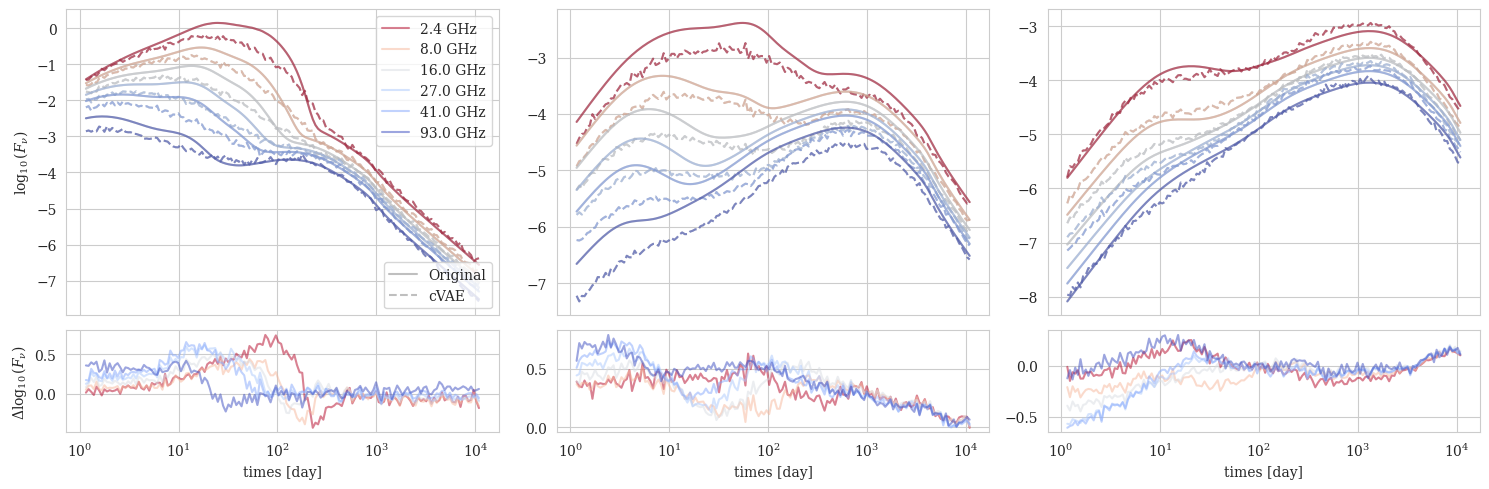

In [84]:
def plot_lcs(tasks, model):

    freqs = np.unique(pars[:,features_names.index("freq")])
    norm = LogNorm(vmin=np.min(freqs),
                   vmax=np.max(freqs))
    cmap_name = "coolwarm_r" # 'coolwarm_r'
    cmap = plt.get_cmap(cmap_name)

    fig, axes = plt.subplots(2,3, figsize=(15,5), sharex='all', 
                           gridspec_kw={'height_ratios': [3, 1]})
    for i, task in enumerate(tasks):
        req_pars = copy.deepcopy(task["pars"])
        # pars = [req_pars[feat] for feat in features_names]
        l2s = []
        for freq in freqs:
            
            # get light curve from training data
            mask = np.ones_like(pars[:,0],dtype=bool)
            req_pars["freq"] = freq
            for j, par in enumerate(features_names):
                i_mask = pars[:,j] == req_pars[par]
                if np.sum(i_mask) == 0:
                    raise ValueError(f"par={par} requested {req_pars[par]} not found in data\n{np.unique(pars[:,j])}")
                mask = (mask & i_mask)
            if np.sum(mask) > 1:
                raise ValueError("error in extracting LC from train data")
            # expected array with one index
            lc = np.log10(np.array(lcs[mask, :])).flatten()
            
            
            
            l11, = axes[0, i].plot(times/86400, lc,ls='-', color='gray', alpha=0.5, label=f"Original") # for second legend
            l21, = axes[0, i].plot(times/86400, lc,ls='-', color=cmap(norm(freq)), alpha=0.5, label=f"{freq/1e9:.1f} GHz")
            l2s.append(l21)

            # get light curve from model
            # get list of parameters from dictionary
            req_pars_list = [np.float32(req_pars[feat]) for feat in features_names]
            lc_nn = np.log10(np.array(inference(req_pars_list,model,dataset,device)).flatten())
            l12, = axes[0, i].plot(times/86400, lc_nn,ls='--', color='gray', alpha=0.5, label=f"cVAE") # for second legend
            l22, = axes[0, i].plot(times/86400, lc_nn,ls='--', color=cmap(norm(freq)), alpha=0.5)

            
            # plot difference
            axes[1, i].plot(times/86400, lc-lc_nn, ls='-', color=cmap(norm(freq)), alpha=0.5)

        axes[0, i].set_xscale("log")
        axes[1, i].set_xlabel(r"times [day]")

    axes[0,0].set_ylabel(r'$\log_{10}(F_{\nu})$')
    axes[1,0].set_ylabel(r'$\Delta\log_{10}(F_{\nu})$')

    first_legend = axes[0,0].legend(handles=l2s, loc='upper right')

    axes[0,0].add_artist(first_legend)
    axes[0,0].legend(handles=[l11,l12], loc='lower right')

    plt.tight_layout()
    plt.show()
tasks = [
    {"pars":{"eps_e":0.001,"eps_b":0.01,"eps_t":1.,"p":2.2,"theta_obs":0.,"n_ism":1e0}, "all_freqs":True},
    {"pars":{"eps_e":0.01,"eps_b":0.01,"eps_t":1.,"p":2.2,"theta_obs":0.,"n_ism":0.01}, "all_freqs":True},
    {"pars":{"eps_e":0.1,"eps_b":0.01,"eps_t":1.,"p":2.2,"theta_obs":0.,"n_ism":0.001}, "all_freqs":True},
]
plot_lcs(tasks, model)

In [12]:
# compute lightcurves for train data
def compute_all_nn_lcs():
    return np.vstack((
        [inference(pars[j, :], model, dataset, device) for j in range(len(pars[:,0]))]
    ))
nn_lcs = compute_all_nn_lcs()
print(f"lcs={lcs.shape} nn_lcs={nn_lcs.shape}")

lcs=(43200, 150) nn_lcs=(43200, 150)


# Plot the model performance using Violin Plots

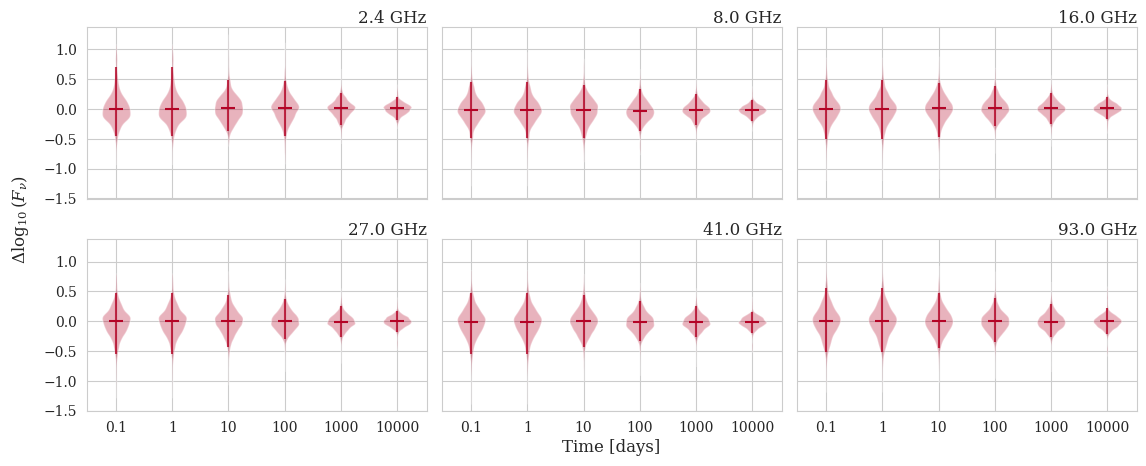

(43200, 150) (43200, 150)


In [94]:
# Plot Violin
def find_nearest_index(array, value):
    ''' Finds index of the value in the array that is the closest to the provided one '''
    idx = (np.abs(array - value)).argmin()
    return idx
def plot_violin():
    cmap_name = "coolwarm_r" # 'coolwarm_r'
    cmap = plt.get_cmap(cmap_name)
    
    freqs = np.unique(pars[:,features_names.index("freq")])
    norm = LogNorm(vmin=np.min(freqs),
                   vmax=np.max(freqs))

    req_times = np.array([0.1, 1., 10., 100., 1000., 1e4]) * 86400.

    log_lcs = np.log10(lcs)
    log_nn_lcs = np.log10(nn_lcs)
    delta = log_lcs - log_nn_lcs
    
    fig, axes = fig, ax = plt.subplots(2, 3, figsize=(12, 5), sharex="all", sharey="all")
    ax = ax.flatten()
    for ifreq, freq in enumerate(freqs):
        i_mask1 = pars[:, features_names.index("freq")] == freq

        _delta = delta[i_mask1]
        time_indeces = [find_nearest_index(times, t) for t in req_times]
        _delta = _delta[:, time_indeces]
        
        color = cmap(norm(freqs[0]))
        
        if np.sum(_delta) == 0:
            raise ValueError(f"np.sum(delta) == 0 delta={_delta.shape}")
        # print(_delta.shape)
        violin = ax[ifreq].violinplot(_delta, positions=range(len(req_times)), showextrema=False, showmedians=True)

        
        for pc in violin['bodies']:
            pc.set_facecolor(color)
        violin['cmedians'].set_color(color)
        for it, t in enumerate(req_times):
            ax[ifreq].vlines(it, np.quantile(_delta[:,it], 0.025), np.quantile(_delta[:,it], 0.975), color=color, linestyle='-', alpha=.8)

        # ax[ifreq].hlines([-1,0,1], 0.1, 6.5, colors='gray', linestyles=['dashed', 'dotted', 'dashed'], alpha=0.5)


        ax[ifreq].set_xticks(np.arange(0, len(req_times)))
        # print(ax[ifreq].get_xticklabels(), ax[ifreq])
        _str = lambda t : '{:.1f}'.format(t/86400.) if t/86400. < 1 else '{:.0f}'.format(t/86400.)
        ax[ifreq].set_xticklabels([_str(t) for t in req_times])

        ax[ifreq].annotate(f"{freq/1e9:.1f} GHz", xy=(1, 1),xycoords='axes fraction', fontsize=12, horizontalalignment='right', verticalalignment='bottom')


# Create the new axis for marginal X and Y labels
    ax = fig.add_subplot(111, frameon=False)
    
    # Disable ticks. using ax.tick_params() works as well
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set X and Y label. Add labelpad so that the text does not overlap the ticks
    ax.set_xlabel(r"Time [days]", labelpad=20, fontsize=12)
    ax.set_ylabel(r"$\Delta \log_{10}(F_{\nu})$", labelpad=40, fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    print(lcs.shape, nn_lcs.shape)    
plot_violin()

# Old simple method to plot training data and model

(43200, 7) (7,)
(1, 7) (43200,)


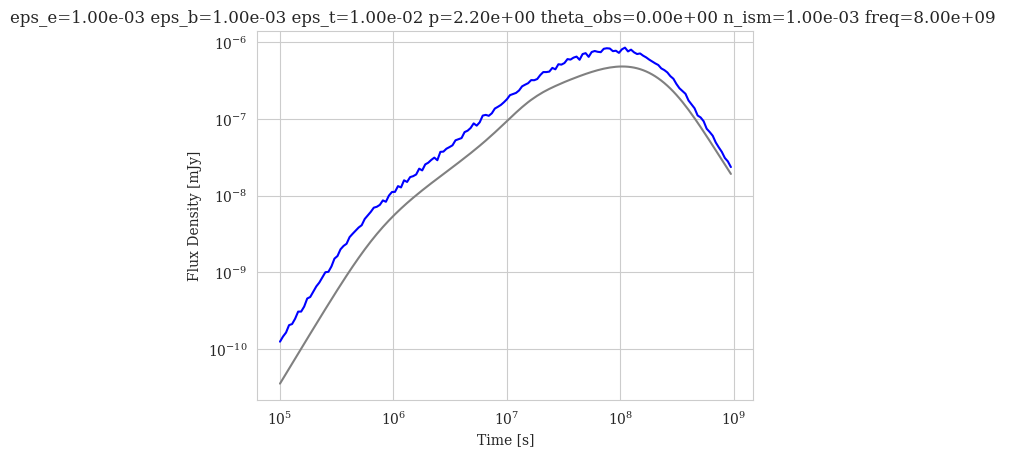

(43200, 7) (7,)
(1, 7) (43200,)


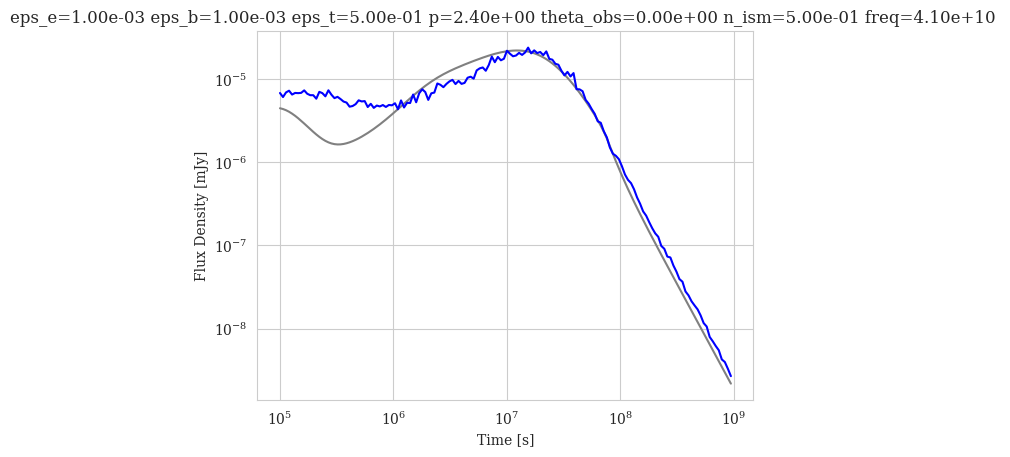

(43200, 7) (7,)
(1, 7) (43200,)


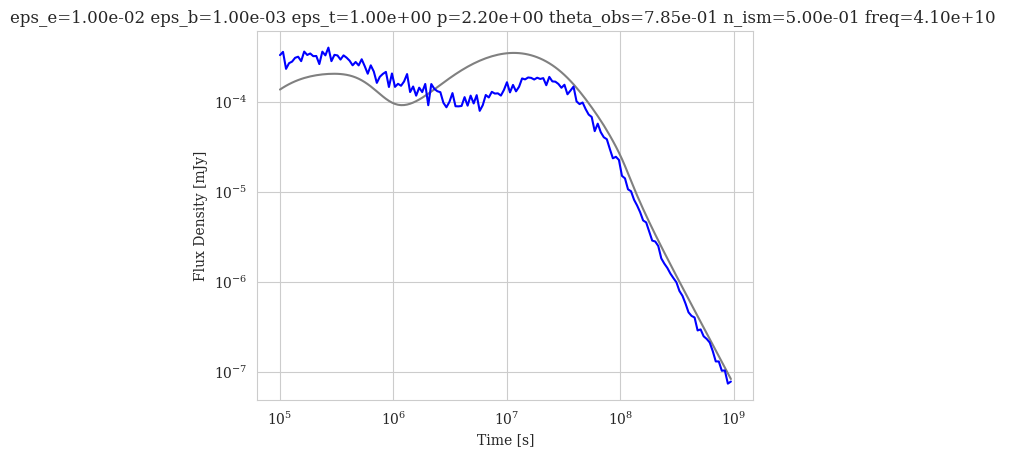

In [13]:
def plot_one(i = 0):

    lc = lcs[i]
    par = pars[i]
    print(pars.shape, par.shape)
    title = "".join([_par+"="+f"{_val:.2e} " for _par,_val in zip(features_names,par)])
    plt.loglog(times, lc, color='gray')

    lc_nn = inference(par, model, dataset, device)
    lc_nn = lc_nn[0]
    plt.ylabel("Flux Density [mJy]")
    plt.xlabel("Time [s]")
    plt.loglog(times, lc_nn, color='blue')
    plt.title(title)
    plt.show()

plot_one(1)
plot_one(1000)
plot_one(10000)